In [4]:
import random

import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import torch
import torch.nn as nn

from keras.preprocessing.sequence import TimeseriesGenerator
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.layers import (
    LSTM,
    Dense,
    Reshape,
    Input,
    ConvLSTM2D,
    ConvLSTM1D,
    Flatten,
    RepeatVector,
    TimeDistributed,
)

from matplotlib import pyplot as plt
from datetime import datetime, timedelta

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    LeaveOneOut,
    GridSearchCV,
)


import warnings

warnings.filterwarnings("ignore")

In [5]:
df_track = pd.read_excel("./Simusafe_Dataset/Feature_Track.xlsx")
df_track.head()

,Unnamed: 0,subject,lap,start_time,straight,roundabout_entry,roundabout_exit,zebra_crossing,left_turn,u_turn,...,LowerAlphaFrontal,LowerAlphaParietal,UpperAlphaFrontal,UpperAlphaParietal,BetaFrontal,BetaParietal,LowerBetaFrontal,LowerBetaParietal,UpperBetaFrontal,UpperBetaParietal
0,0,0AC2A4,1,7,1,1,0,0,1,0,...,0.13222,0.08812,0.13469,0.08590,0.05499,0.04078,0.08419,0.06275,0.03722,0.02711
1,1,0AC2A4,1,27,1,0,1,0,1,0,...,0.13639,0.08118,0.12483,0.07588,0.04060,0.02869,0.05951,0.04759,0.02963,0.01753
2,2,0AC2A4,1,33,1,0,0,1,1,0,...,0.19671,0.11480,0.10121,0.09079,0.04339,0.02727,0.06250,0.04305,0.03296,0.01751
3,3,0AC2A4,1,43,1,1,0,0,0,0,...,0.20826,0.12873,0.11832,0.11087,0.04872,0.02917,0.06894,0.04766,0.03627,0.01744
4,4,0AC2A4,1,58,1,1,0,0,0,0,...,0.21193,0.14454,0.13428,0.13604,0.04173,0.02743,0.05937,0.04344,0.03132,0.01762


In [6]:
df_track.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 89 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     1056 non-null   int64  
 1   subject                        1056 non-null   object 
 2   lap                            1056 non-null   int64  
 3   start_time                     1056 non-null   int64  
 4   straight                       1056 non-null   int64  
 5   roundabout_entry               1056 non-null   int64  
 6   roundabout_exit                1056 non-null   int64  
 7   zebra_crossing                 1056 non-null   int64  
 8   left_turn                      1056 non-null   int64  
 9   u_turn                         1056 non-null   int64  
 10  bypass_dummy                   1056 non-null   int64  
 11  car                            1056 non-null   int64  
 12  pedestrian                     1056 non-null   i

In [7]:
scenario_data = ["subject", "lap", "start_time"]
vehicular_data = [
    "max_speed",
    "avg_speed",
    "std_speed",
    "yaw",
    "yaw_rate",
    "roll",
    "roll_rate",
    "pitch",
    "pitch_rate",
    "lat_acce",
    "long_acce",
    "vert_acce",
    "avg_acce_pedal_pos",
    "std_acce_pedal_pos",
    "avg_steer_angle",
    "std_steer_angle",
]
neurophysiological_data = [
    "hr",
    "hrv_lf",
    "hrv_hf",
    "hrv_lfhf_ratio",
    "gsr_tonic",
    "gsr_phasic",
    "gsr_peaks",
    "EBRmean",
    "BDmean",
    "ThetaFrontal",
    "ThetaParietal",
    "AlphaFrontal",
    "AlphaParietal",
    "LowerAlphaFrontal",
    "LowerAlphaParietal",
    "UpperAlphaFrontal",
    "UpperAlphaParietal",
    "BetaFrontal",
    "BetaParietal",
    "LowerBetaFrontal",
    "LowerBetaParietal",
    "UpperBetaFrontal",
    "UpperBetaParietal",
]

In [8]:
df_simulated = pd.read_excel("./Simusafe_Dataset/Feature_Simulation.xlsx")
df_simulated.head()

,Unnamed: 0,subject,lap,start_time,straight,roundabout_entry,roundabout_exit,zebra_crossing,left_turn,u_turn,...,LowerAlphaFrontal,LowerAlphaParietal,UpperAlphaFrontal,UpperAlphaParietal,BetaFrontal,BetaParietal,LowerBetaFrontal,LowerBetaParietal,UpperBetaFrontal,UpperBetaParietal
0,0,0AC2A4,1,13,1,0,0,1,0,0,...,0.12420,0.07737,0.12307,0.07681,0.05046,0.03492,0.07430,0.05289,0.03606,0.02393
1,1,0AC2A4,1,32,0,1,0,1,0,0,...,0.20402,0.10296,0.14606,0.10325,0.03636,0.02433,0.05822,0.04136,0.02535,0.01391
2,2,0AC2A4,1,36,0,0,1,1,0,0,...,0.20329,0.12355,0.09483,0.08173,0.04524,0.02847,0.06055,0.04321,0.03586,0.01923
3,3,0AC2A4,1,42,1,0,0,0,0,0,...,0.20325,0.12153,0.11255,0.10920,0.04928,0.02923,0.07192,0.04653,0.03536,0.01832
4,4,0AC2A4,1,52,1,0,0,0,0,1,...,0.19645,0.13454,0.13270,0.13759,0.04501,0.02943,0.06175,0.04715,0.03511,0.01838


In [9]:
df_simulated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1287 entries, 0 to 1286
Data columns (total 89 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     1287 non-null   int64  
 1   subject                        1287 non-null   object 
 2   lap                            1287 non-null   int64  
 3   start_time                     1287 non-null   int64  
 4   straight                       1287 non-null   int64  
 5   roundabout_entry               1287 non-null   int64  
 6   roundabout_exit                1287 non-null   int64  
 7   zebra_crossing                 1287 non-null   int64  
 8   left_turn                      1287 non-null   int64  
 9   u_turn                         1287 non-null   int64  
 10  bypass_dummy                   1287 non-null   int64  
 11  car                            1287 non-null   int64  
 12  pedestrian                     1287 non-null   i

In [10]:
df_simulated["source"] = "simulation"
df_track["source"] = "track"

combined_features = pd.concat([df_simulated, df_track], ignore_index=True)

In [11]:
scenario_data = ["subject", "lap", "start_time"]
vehicular_data = [
    "max_speed",
    "avg_speed",
    "std_speed",
    "yaw",
    "yaw_rate",
    "roll",
    "roll_rate",
    "pitch",
    "pitch_rate",
    "lat_acce",
    "long_acce",
    "vert_acce",
    "avg_acce_pedal_pos",
    "std_acce_pedal_pos",
    "avg_steer_angle",
    "std_steer_angle",
]
neurophysiological_data = [
    "hr",
    "hrv_lf",
    "hrv_hf",
    "hrv_lfhf_ratio",
    "gsr_tonic",
    "gsr_phasic",
    "gsr_peaks",
    "EBRmean",
    "BDmean",
    "ThetaFrontal",
    "ThetaParietal",
    "AlphaFrontal",
    "AlphaParietal",
    "LowerAlphaFrontal",
    "LowerAlphaParietal",
    "UpperAlphaFrontal",
    "UpperAlphaParietal",
    "BetaFrontal",
    "BetaParietal",
    "LowerBetaFrontal",
    "LowerBetaParietal",
    "UpperBetaFrontal",
    "UpperBetaParietal",
]

In [12]:
data = combined_features.copy()

In [13]:
cols_to_drop = ["Unnamed: 0"] + scenario_data

In [89]:
data = combined_features.drop(columns=cols_to_drop, axis=1)
data.head()

,straight,roundabout_entry,roundabout_exit,zebra_crossing,left_turn,u_turn,bypass_dummy,car,pedestrian,traffic_light,...,LowerAlphaParietal,UpperAlphaFrontal,UpperAlphaParietal,BetaFrontal,BetaParietal,LowerBetaFrontal,LowerBetaParietal,UpperBetaFrontal,UpperBetaParietal,source
0,1,0,0,1,0,0,0,0,0,0,...,0.07737,0.12307,0.07681,0.05046,0.03492,0.07430,0.05289,0.03606,0.02393,simulation
1,0,1,0,1,0,0,0,0,0,0,...,0.10296,0.14606,0.10325,0.03636,0.02433,0.05822,0.04136,0.02535,0.01391,simulation
2,0,0,1,1,0,0,0,0,0,0,...,0.12355,0.09483,0.08173,0.04524,0.02847,0.06055,0.04321,0.03586,0.01923,simulation
3,1,0,0,0,0,0,0,0,0,0,...,0.12153,0.11255,0.10920,0.04928,0.02923,0.07192,0.04653,0.03536,0.01832,simulation
4,1,0,0,0,0,1,0,0,0,0,...,0.13454,0.13270,0.13759,0.04501,0.02943,0.06175,0.04715,0.03511,0.01838,simulation


In [123]:
def create_sequence(df, current_features, target_feature, sequence_length):
    sequences = []
    targets = []
    for i in range(len(df) - sequence_length):
        sequence = df[current_features].iloc[i : i + sequence_length].values.astype(float)
        # Check NaNs in sequence
        if np.isnan(sequence).any():
            # forwards fill
            sequence = pd.DataFrame(sequence).fillna(method="ffill").values.astype(float)
        target = df[target_feature].iloc[i: i + sequence_length].values.astype(float)
        sequences.append(sequence)
        targets.append(target)
    sequences_series = pd.Series(sequences)
    targets_series = pd.Series(targets)
    return sequences_series, targets_series



In [124]:
target_feature = "risk_evaluation"
current_features = [
    # Neurophysiological data
    "hr",
    "hrv_lf",
    "hrv_hf",
    "hrv_lfhf_ratio",
    "gsr_tonic",
    "gsr_phasic",
    "gsr_peaks",
    "EBRmean",
    "BDmean",
    "ThetaFrontal",
    "ThetaParietal",
    "AlphaFrontal",
    "AlphaParietal",
    "LowerAlphaFrontal",
    "LowerAlphaParietal",
    "UpperAlphaFrontal",
    "UpperAlphaParietal",
    "BetaFrontal",
    "BetaParietal",
    "LowerBetaFrontal",
    "LowerBetaParietal",
    "UpperBetaFrontal",
    "UpperBetaParietal",
    # Video Analysis Data
    'straight',
    'roundabout_entry',
    'roundabout_exit',
    'zebra_crossing',
    'left_turn',
    'u_turn',
    'bypass_dummy',
    'car',
    'pedestrian',
    'traffic_light',
    'narrow_road',
    'dummy',
    'bend',
    'habituation',
    'traffic'
]
sequence_length = 3

In [125]:
# Check and Forward Fill NaNs in Current Features
data[current_features] = data[current_features].fillna(method="ffill")

# check for NaNs
data[current_features].isna().sum()

hr                    0
hrv_lf                0
hrv_hf                0
hrv_lfhf_ratio        0
gsr_tonic             0
gsr_phasic            0
gsr_peaks             0
EBRmean               0
BDmean                0
ThetaFrontal          0
ThetaParietal         0
AlphaFrontal          0
AlphaParietal         0
LowerAlphaFrontal     0
LowerAlphaParietal    0
UpperAlphaFrontal     0
UpperAlphaParietal    0
BetaFrontal           0
BetaParietal          0
LowerBetaFrontal      0
LowerBetaParietal     0
UpperBetaFrontal      0
UpperBetaParietal     0
straight              0
roundabout_entry      0
roundabout_exit       0
zebra_crossing        0
left_turn             0
u_turn                0
bypass_dummy          0
car                   0
pedestrian            0
traffic_light         0
narrow_road           0
dummy                 0
bend                  0
habituation           0
traffic               0
dtype: int64

In [126]:
data[current_features] = data[
    current_features
].apply(pd.to_numeric, errors="coerce")

# scaler = StandardScaler()
# data[current_features] = scaler.fit_transform(
#     data[current_features]
# )

In [127]:
sequences, target= create_sequence(data, current_features, target_feature, sequence_length)
sequences

0       [[64.55194, 0.0345, 0.0165, 2.118, 0.29596, 0....
1       [[66.93432, 0.043, 0.0395, 1.828, 0.295, 0.000...
2       [[69.64516, 0.051, 0.021, 2.49233, 0.2947, 0.0...
3       [[73.94709, 0.0466, 0.0252, 1.9352, 0.29447, 0...
4       [[72.19436, 0.04808, 0.024, 2.06258, 0.29269, ...
                              ...                        
2335    [[96.28941, 0.03856, 0.06433, 0.62856, 0.32991...
2336    [[86.23175, 0.0281, 0.0639, 0.4639, 0.32964, 0...
2337    [[73.47137, 0.03167, 0.09333, 0.34533, 0.32922...
2338    [[71.40761, 0.039, 0.057, 0.68, 0.32904, 0.000...
2339    [[71.40761, 0.039, 0.057, 0.68, 0.32904, 0.000...
Length: 2340, dtype: object

In [128]:
target

0       [0.0, 0.0, 0.0]
1       [0.0, 0.0, 0.0]
2       [0.0, 0.0, 0.0]
3       [0.0, 0.0, 0.0]
4       [0.0, 0.0, 0.0]
             ...       
2335    [0.0, 1.0, 0.0]
2336    [1.0, 0.0, 0.0]
2337    [0.0, 0.0, 0.0]
2338    [0.0, 0.0, 0.0]
2339    [0.0, 0.0, 0.0]
Length: 2340, dtype: object

In [129]:
# Check for NaN values within the sequences
count = 0
for sequence in sequences:
    if np.isnan(sequence).any():
        print(count, " NaN values found")
        count += 1

In [130]:
target.shape

(2340,)

In [131]:
# Train and Test Split for Sequence Data

train_sequences = sequences[:int(len(sequences) * 0.8)]
test_sequences = sequences[int(len(sequences) * 0.8):]

train_sequences.shape, test_sequences.shape

((1872,), (468,))

In [132]:
# Max - Padding in Sequences

train_sequences = pad_sequences(train_sequences, dtype="float32", padding="post")
test_sequences = pad_sequences(test_sequences, dtype="float32", padding="post")

train_sequences.shape, test_sequences.shape

((1872, 3, 38), (468, 3, 38))

In [133]:
target.shape

(2340,)

In [134]:
model = Sequential()
model.add(
    LSTM(128, activation="tanh", input_shape=(sequence_length, len(current_features)))
)
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(3, activation="linear"))
optimizer = Adam(lr=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss="mean_absolute_error")

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 128)               85504     
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dense_33 (Dense)            (None, 32)                2080      
                                                                 
 dense_34 (Dense)            (None, 3)                 99        
                                                                 
Total params: 95,939
Trainable params: 95,939
Non-trainable params: 0
_________________________________________________________________


2024-03-17 23:14:45.992067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-17 23:14:45.992791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-17 23:14:45.993474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [150]:
import tensorflow as tf

target_padded = pad_sequences(target, dtype="float32", padding="post")
train_target = tf.convert_to_tensor(
    target_padded[: int(len(sequences) * 0.8)], dtype=tf.float32
)

test_target = tf.convert_to_tensor(
    target_padded[int(len(sequences) * 0.8) :], dtype=tf.float32
)

train_target.shape, test_target.shape

(TensorShape([1872, 3]), TensorShape([468, 3]))

In [151]:
# Training the Model

history = model.fit(
    train_sequences,
    train_target,
    epochs=15,
    validation_split=0.2,
    shuffle=False,
)


Epoch 1/15
47/47 [==============================] - 0s 3ms/step - loss: 0.1741 - val_loss: 0.0641
Epoch 2/15
47/47 [==============================] - 0s 3ms/step - loss: 0.1742 - val_loss: 0.0636
Epoch 3/15
47/47 [==============================] - 0s 3ms/step - loss: 0.1748 - val_loss: 0.0640
Epoch 4/15
47/47 [==============================] - 0s 3ms/step - loss: 0.1731 - val_loss: 0.0639
Epoch 5/15
47/47 [==============================] - 0s 3ms/step - loss: 0.1737 - val_loss: 0.0635
Epoch 6/15
47/47 [==============================] - 0s 3ms/step - loss: 0.1733 - val_loss: 0.0628
Epoch 7/15
47/47 [==============================] - 0s 3ms/step - loss: 0.1741 - val_loss: 0.0653
Epoch 8/15
47/47 [==============================] - 0s 3ms/step - loss: 0.1751 - val_loss: 0.0674
Epoch 9/15
47/47 [==============================] - 0s 3ms/step - loss: 0.1744 - val_loss: 0.0642
Epoch 10/15
47/47 [==============================] - 0s 3ms/step - loss: 0.1739 - val_loss: 0.0681
Epoch 11/15
47/47 [

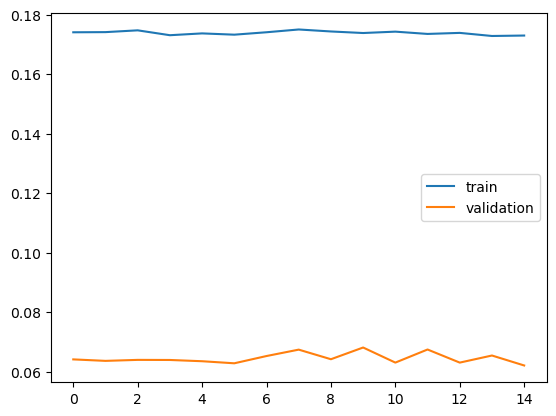

In [152]:
# Plotting the Loss and Accuracy
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.show()

In [156]:
# One Hot Encoding the Target
from keras.utils import to_categorical

target_padded = pad_sequences(target, dtype="float32", padding="post")
target_padded = to_categorical(target_padded, num_classes=3)
target_padded.shape


(2340, 3, 3)

In [160]:
train_target_encoder_decoder = target_padded[: int(len(sequences) * 0.8)]
test_target_encoder_decoder = target_padded[int(len(sequences) * 0.8) :]

In [165]:
# Encoder-Decoder LSTM Model for ((1872, 3, 38), (468, 3, 38))

num_classes = 3
input_shape = (3, 38)  # Sequence length, Number of features

# Encoder
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = RepeatVector(input_shape[0])(encoder_outputs)
decoder_lstm = LSTM(128, return_sequences=True, return_state=False)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = TimeDistributed(Dense(num_classes, activation="softmax"))
decoder_outputs = decoder_dense(decoder_outputs)


# Model

encoder_decoder_model = Model(encoder_inputs, decoder_outputs)

# Compile the model
OPTIMIZER = Adam(lr=0.001, clipvalue=1.0)
encoder_decoder_model.compile(optimizer=OPTIMIZER, loss="categorical_crossentropy", metrics=["accuracy"])
encoder_decoder_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 3, 38)]      0           []                               
                                                                                                  
 lstm_42 (LSTM)                 [(None, 128),        85504       ['input_22[0][0]']               
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 repeat_vector_7 (RepeatVector)  (None, 3, 128)      0           ['lstm_42[0][0]']                
                                                                                           

2024-03-17 23:32:21.473244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-17 23:32:21.473794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-17 23:32:21.474351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [166]:
# Training the Model
history = encoder_decoder_model.fit(
    train_sequences,
    train_target_encoder_decoder,
    epochs=150,
    validation_split=0.2,
    shuffle=False,
)

Epoch 1/150


2024-03-17 23:32:21.994093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-17 23:32:21.995242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-17 23:32:21.995997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

43/47 [==========================>...] - ETA: 0s - loss: 0.5619 - accuracy: 0.7929

2024-03-17 23:32:23.676262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-17 23:32:23.677064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-17 23:32:23.677719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

47/47 [==============================] - 2s 13ms/step - loss: 0.5431 - accuracy: 0.8094 - val_loss: 0.3119 - val_accuracy: 0.9396
Epoch 2/150
47/47 [==============================] - 0s 6ms/step - loss: 0.4977 - accuracy: 0.8314 - val_loss: 0.3607 - val_accuracy: 0.9396
Epoch 3/150
47/47 [==============================] - 0s 6ms/step - loss: 0.4997 - accuracy: 0.8314 - val_loss: 0.3900 - val_accuracy: 0.9396
Epoch 4/150
47/47 [==============================] - 0s 6ms/step - loss: 0.4954 - accuracy: 0.8314 - val_loss: 0.3839 - val_accuracy: 0.9396
Epoch 5/150
47/47 [==============================] - 0s 6ms/step - loss: 0.4900 - accuracy: 0.8314 - val_loss: 0.3699 - val_accuracy: 0.9396
Epoch 6/150
47/47 [==============================] - 0s 6ms/step - loss: 0.4859 - accuracy: 0.8314 - val_loss: 0.3650 - val_accuracy: 0.9396
Epoch 7/150
47/47 [==============================] - 0s 6ms/step - loss: 0.4827 - accuracy: 0.8314 - val_loss: 0.3613 - val_accuracy: 0.9396
Epoch 8/150
47/47 [=====

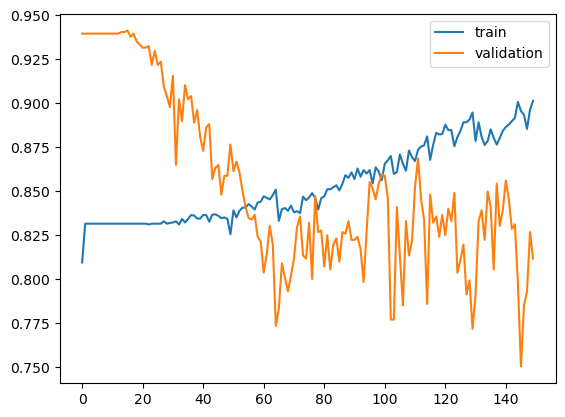

In [167]:
# Plotting the Accuracy
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
